In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## RNG
rng = np.random.default_rng()


def get_norm_factor(v):
    """get complex number alpha which rescales
    complex eigenvector v=vr + i(vi) such that:
    1. vr.T @ vi = 0 [orthogonality]
    2. vr.T @ vr = 1 [normalized real component]
    3. (vr.T @ vr) >= (vi.T @ vi)"""

    ## get real/imag. components
    vr = v.real
    vi = v.imag

    ## Define coefficients for convenience
    a = vr.T @ vr
    b = vi.T @ vi
    c = vr.T @ vi

    ## Compute rotation angle
    phi0 = 1 / 2 * np.arctan(2 * c / (b - a))

    ## compute non-normalized rotation
    R = lambda phi: np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    vtilde0 = np.stack([vr, vi], axis=1) @ R(phi0)

    ## compute norm of each rotated vector
    norm = np.sum(vtilde0**2, axis=0)

    # get length of longer vector
    max_idx = np.argmax(norm)
    scale = np.sqrt(norm[max_idx])

    # make sure real component of transformed vector is larger
    if max_idx == 0:
        phi1 = phi0
    else:
        phi1 = phi0 + np.pi / 2

    ## make sure real part of transformed first element is real
    ## to preserve complex conjugacy b/n pairs of eigenvectors
    vtilde1 = np.exp(1j * phi1) * v
    if vtilde1[0].real < 0:
        phi2 = phi1 + np.pi
    else:
        phi2 = phi1

    ## final complex number for transformation
    alpha = 1 / scale * np.exp(1j * phi2)

    return alpha

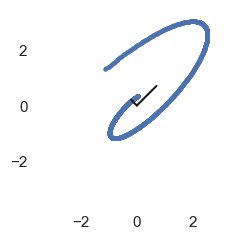

In [3]:
## specify params
BJ = -0.5
R = -1.5
eps = R - BJ
F1 = 1.5
F2 = F1

## linear operator
L = np.array([[R, F1], [-F2, -eps]])

## Get eigs
gamma, V = np.linalg.eig(L)
V_inv = np.linalg.inv(V)

## rotate to be orthogonal
alpha = get_norm_factor(V[:, 0])
V *= alpha

## initial condition and times to evaluate
x0 = rng.normal(size=2)
t = np.linspace(0, 8, 800)

## greens matrix
G = np.einsum("mk,kt,kn->mtn", V, np.exp(np.einsum("k,n->kn", gamma, t)), V_inv)

## solution
x = np.einsum("mtn,n->mt", G, x0).real

## plot setup
fig, ax = plt.subplots(figsize=(2.5, 2.5))

## plot eigs
ax.plot([0, V[0, 0].real], [0, V[1, 0].real], c="k")
ax.plot([0, V[0, 0].imag], [0, V[1, 0].imag], c="k")


## plot data
ax.scatter(x[0], x[1], s=5)

## set specs
amp = 2 * np.sqrt(np.sum(x0**2))
ax.set_xlim([-amp, amp])
ax.set_ylim([-amp, amp])
ax.set_aspect("equal")

plt.show()